In [1]:
import math
import os
import subprocess
import time
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import itertools
import pickle
from tabulate import tabulate
from skopt import gp_minimize
from g4beam import *
from tqdm import *

In [13]:
t_emit = 0.145  # mm
momentum = 100  # MeV/c
beta = 0.03    # m
alpha = 0.7     # dimensionless
l_emit = 1      # mm
pz_std = 1    # MeV/c
vd_dist = 24    # mm

pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=20000)
pre_w1["PDGid"] = -13
print(pre_w1)
print_all_params(pre_w1)

              x         y  z         Px         Py          Pz         t  \
0     -1.774893 -2.692219  0  -3.029789  13.579239   98.873775  0.153125   
1     -2.912972  0.003809  0   7.062870   2.200567  100.831862 -0.229067   
2     -1.800323  2.170267  0   0.554970  -7.764129  100.902903  1.006014   
3      2.975957 -1.791058  0  -3.222081  -0.677884   99.991895 -1.862423   
4      6.046799 -0.207787  0 -14.224190  -8.096080   99.517274  0.247100   
...         ...       ... ..        ...        ...         ...       ...   
19995 -3.200191 -3.389964  0  -7.266278   6.108819  100.668486  0.724782   
19996  1.915938 -2.057868  0   0.511951   9.565056   98.631183 -0.893762   
19997  2.947306  0.296231  0  -0.731612  -0.057003   99.926957 -1.921238   
19998  3.899114  1.394507  0 -18.249205   3.795331   98.216734  0.320823   
19999 -0.851112  1.901848  0  16.458944 -10.793507   99.177943 -0.345341   

       PDGid  EventID  TrackID  ...  ProperTime  PathLength PolX PolY PolZ  \
0        

In [19]:
## FIRST WEDGE
def func(x):
    length, angle = x
    return emittances(cut_outliers(run_distribution(pre_w1, length, angle, vd_dist, axis=0)))[0]

start = time.time()
print("optim result")
optim_result = minimize(func, [7.5, 45], method="Nelder-Mead", bounds=((1, 10), (30, 70)), options=dict(fatol=1e-6))

# Get results
w1_length, w1_angle = optim_result.x
print(f"Length = {w1_length:.2f} mm\nAngle = {w1_angle:.1f} deg")
print("Time spent:", time.time()-start)

# Runs a single case with the optimal parameters
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
print("without cutting outliers")
print_all_params(post_w1)
print("with cutting outliers")
print_all_params(cut_outliers(post_w1))

optim result
iter value
  35 4.23354e-02
Length = 7.26 mm
Angle = 46.9 deg
Time spent: 784.885635137558
without cutting outliers
-----------------------------
Twiss parameters for X
emit  = 0.04818573438521057 mm
beta  = 0.03473228951115667 m
gamma = 186.02811533356086 1/m
alpha = -2.336917276879967
D     = 0.020056974738646396 m
D'    = -0.039695860304150406

Twiss parameters for Y
emit  = 0.1518613560040822 mm
beta  = 0.02536421924122367 m
gamma = 58.304926962819486 1/m
alpha = -0.6919963513837962
D     = 2.130551796633419e-06 m
D'    = 0.00991429861908642

Z-emittance:  6.4780584902771965 mm
Z std: 143.1409949221901 mm
p std: 7.257689080547358 MeV/c
Mean momentum: 87.69861194009424 MeV/c
-----------------------------
with cutting outliers
-----------------------------
Twiss parameters for X
emit  = 0.04233543919286648 mm
beta  = 0.0367334224089604 m
gamma = 203.92716439627728 1/m
alpha = -2.5477328491091766
D     = 0.02019011070088135 m
D'    = -0.061094853534076156

Twiss parameter

In [20]:
##Dispersion correction and transverse separation
post_correct = remove_dispersion(post_w1)

# Ignore transverse momentums
no_transverse = remove_transverse(post_correct)

# Reverse transverse momentums in saved copy
reverse_transverse = post_correct.copy(deep=True)
reverse_transverse["Px"] *= -1
reverse_transverse["Py"] *= -1

In [21]:
##Phase rotation

drift_length = 16000
rf_freq = 0.025

start = time.time()
# Function to optimize
def func(x):
    rf_phase, rf_length, rf_grad = x
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    post_cavity = run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad, nparticles=len(no_transverse))
    pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
    return np.std(p_total(cut_pz(pre_w2)))

# Run optimization
optim_result = minimize(func, [0, 4700, 7], method="Nelder-Mead", bounds=((-90, 90), (2000, 6000), (1, 10)), options=dict(fatol=1e-6))

# Get results
rf_phase, rf_length, rf_grad = optim_result.x
print(f"Phase = {rf_phase:.2f} deg\nLength = {rf_length:.0f} mm\nGradient = {rf_grad:.2f} MV/m\nFrequency = {rf_freq*1000:.1f} MHz")
print("Time spent:", time.time()-start)

# Runs a single case with the optimal parameters and add the transverse back in
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, 1))
print(post_drift)
post_cavity = cut_pz(recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad)))
pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
print_all_params(pre_w2)

iter value
 204 1.31144e+00
Phase = 0.00 deg
Length = 5530 mm
Gradient = 4.91 MV/m
Frequency = 25.0 MHz
Time spent: 179362.11481785774
              x         y  z  Px  Py       Pz         t  PDGid  EventID  \
0     -0.853479  0.795275  1   0   0  78.8396  0.144636    -13        1   
1      0.000057  1.168308  1   0   0  84.0717 -0.235543    -13        2   
2      0.414227 -0.009821  1   0   0  81.6165  0.998280    -13        3   
3      0.366508 -1.954977  1   0   0  96.6173 -1.864394    -13        4   
4     -0.535226 -2.241950  1   0   0  99.5173  0.246892    -13        5   
...         ...       ... ..  ..  ..      ...       ...    ...      ...   
19995 -0.871566 -1.813363  1   0   0  73.8119  0.711480    -13    19996   
19996  0.356383  0.184353  1   0   0  94.0731 -0.895931    -13    19997   
19997  0.225849  0.391110  1   0   0  97.9824 -1.922787    -13    19998   
19998 -2.262340  2.105493  1   0   0  91.4318  0.318684    -13    19999   
19999  2.088254 -0.378313  1   0   0  91

In [22]:
##Phase rotation Using Bayesion Results 

drift_length = 16000
rf_freq = 0.025

start = time.time()
# Function to optimize

"""
def func(x):
    rf_phase, rf_length, rf_grad = x
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    post_cavity = run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad, nparticles=len(no_transverse))
    pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
    return np.std(p_total(cut_pz(pre_w2)))

# Run optimization
optim_result = minimize(func, [0, 4700, 7], method="Nelder-Mead", bounds=((-90, 90), (2000, 6000), (1, 10)), options=dict(fatol=1e-6))
"""
"""
# Get results
###rf_phase, rf_length, rf_grad = optim_result.x
print(f"Phase = {rf_phase:.2f} deg\nLength = {rf_length:.0f} mm\nGradient = {rf_grad:.2f} MV/m\nFrequency = {rf_freq*1000:.1f} MHz")
print("Time spent:", time.time()-start)
"""

# Runs a single case with the optimal parameters and add the transverse back in
drift_to_start = drift_length-res.x[1]/2
post_drift = recenter_t(z_prop(no_transverse, 1))
print(post_drift)
post_cavity_bays = cut_pz(recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=res.x[1], frfcool=rf_freq, ficool=res.x[0], Vrfcool=res.x[2])))
pre_w2_bays = recombine_transverse(post_cavity_bays, reverse_transverse)
print_all_params(pre_w2_bays)

              x         y  z  Px  Py       Pz         t  PDGid  EventID  \
0     -0.853479  0.795275  1   0   0  78.8396  0.144636    -13        1   
1      0.000057  1.168308  1   0   0  84.0717 -0.235543    -13        2   
2      0.414227 -0.009821  1   0   0  81.6165  0.998280    -13        3   
3      0.366508 -1.954977  1   0   0  96.6173 -1.864394    -13        4   
4     -0.535226 -2.241950  1   0   0  99.5173  0.246892    -13        5   
...         ...       ... ..  ..  ..      ...       ...    ...      ...   
19995 -0.871566 -1.813363  1   0   0  73.8119  0.711480    -13    19996   
19996  0.356383  0.184353  1   0   0  94.0731 -0.895931    -13    19997   
19997  0.225849  0.391110  1   0   0  97.9824 -1.922787    -13    19998   
19998 -2.262340  2.105493  1   0   0  91.4318  0.318684    -13    19999   
19999  2.088254 -0.378313  1   0   0  91.6688 -0.347652    -13    20000   

       TrackID  ...  ProperTime  PathLength  PolX  PolY  PolZ     InitX  \
0            1  ...    0

In [ ]:
##Second Wedge

start = time.time()
# Function to optimize
def func(x):
    length, angle = x
    return emittances(cut_outliers(run_distribution(pre_w2, length, angle, vd_dist, axis=1)))[1]

# Run optimization
optim_result = minimize(func, [5.5, 45], method="Nelder-Mead", bounds=((1, 10), (30, 70)), options=dict(fatol=1e-6))

# Get results
w2_length, w2_angle = optim_result.x
print(f"Length = {w2_length:.2f} mm\nAngle = {w2_angle:.1f} deg")
print("Time spent:", time.time()-start)

# Runs a single case with the optimal parameters
post_w2 = run_distribution(pre_w2, w2_length, w2_angle, vd_dist, axis=1)
print_all_params(post_w2)

# Do cuts at this point
post_w2_cut = cut_outliers(post_w2)
print_all_params(post_w2_cut)

In [16]:
results = []
def callback(res):
    x = res.x
    y = f(x)
    results.append((x, y))
    
def f(x):
    params = {
        't_emit': 0.145, # mm
        'momentum': 100, # MeV/c
        'beta': 0.03, # m
        'alpha': 1, # dimensionless
        'l_emit': 1, # mm
        'pz_std': 1, # MeV/c
        'vd_dist': 24, # mm
        'w1_length': 9.207510617,
        'w1_angle': 49.78231334,
        'w2_length': 6.724887901827298,
        'w2_angle': 42.245718529695516,
        'drift_length': 16000,
        'rf_freq': 0.025,
        'rf_phase': x[0],
        'rf_length': x[1],
        'rf_grad': x[2]
    }
    return run(params)

def run(params):
    # Run best case
    pre_w1 = gen_distribution(
        (params["beta"], params["alpha"], params["t_emit"], 0, 0),
        (params["beta"], params["alpha"], params["t_emit"], 0, 0),
        params["momentum"],
        params["pz_std"],
        z_emit=params["l_emit"],
        N=50000)
    pre_w1["PDGid"] = -13
    print("Running first wedge")
    post_w1 = run_distribution(
        pre_w1,
        params["w1_length"],
        params["w1_angle"],
        params["vd_dist"],
        axis=0)
    # post_correct = post_w1
    post_correct = remove_dispersion(post_w1)
    reverse_transverse = post_correct.copy(deep=True)
    reverse_transverse["Px"] *= -1
    reverse_transverse["Py"] *= -1
    drift_to_start = params["drift_length"]-params["rf_length"]/2
    post_drift = recenter_t(z_prop(post_correct, drift_to_start))
    no_transverse = remove_transverse(post_drift)
    print("Running RF cavity")
    post_cavity = cut_pz(recenter_t(run_g4beam(no_transverse, "G4_RFCavity.g4bl", RF_length=params["rf_length"], frfcool=params["rf_freq"], ficool=params["rf_phase"], Vrfcool=params["rf_grad"], nparticles=len(no_transverse))), tails=0.15)
    pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
    return np.std(p_total(cut_pz(pre_w2)))

    
    print("Running second wedge")
    """
    post_w2 = run_distribution(
        pre_w2,
        params["w2_length"],
        params["w2_angle"],
        params["vd_dist"],
        axis=1
    )
    post_w2_cut = recenter_t(cut_outliers(post_w2))
    #print_all_params(post_w2_cut)
    

    # get distributions
    # emits = {}
    # SAMPLE_DISTS = [pre_w1, post_correct, pre_w2, post_w2, post_w2_cut]
    # SAMPLE_TITLES = ["Initial distribution", "After first wedge", "After RF cavity + 15% cut", "After second wedge", "After 4 sigma cut"]
    # for sample, dist in zip(SAMPLE_TITLES, SAMPLE_DISTS):
    #     x_emit, y_emit, z_emit = emittances(cut_outliers(run_distribution(dist, params["w1_length"], params["w1_angle"], params["vd_dist"], axis=0)))
    #     print(f"{sample}: ", x_emit, y_emit, z_emit)
    #     emits[sample] = [x_emit, y_emit, z_emit]
    # return emits

    return emittances(cut_outliers(run_distribution(post_w2, params["w2_length"], params["w2_angle"], params["vd_dist"], axis=0)))
    """

if __name__ == "__main__":
    # list of parameters to optimize
    params = {
        't_emit': 0.145, # mm
        'momentum': 100, # MeV/c
        'beta': 0.03, # m
        'alpha': 1, # dimensionless
        'l_emit': 1, # mm
        'pz_std': 1, # MeV/c
        'vd_dist': 24, # mm
        'w1_length': 9.20751061747799,
        'w1_angle': 49.78231333988419,
        'w2_length': 6.724887901827298,
        'w2_angle': 42.245718529695516,
        'drift_length': 16000,
        'rf_freq': 0.025,
        'rf_phase': 0.001987066319906211,
        'rf_length': 5153.756925848655,
        'rf_grad': 4.046563465382562
    }
    
    
    # example of full run through
    # start = time.time()
    # emits = run(params)
    # print(f"Time elapsed: {time.time() - start:.1f}")
    # print(emits)
    np.int = int
    res = gp_minimize(f,                  # the function to minimize
                      [
                        (float(-90), float(90)), (float(2000), float(6000)), (float(1), float(10))          # bounds on 1st wedge length
                                  # bounds on 1st wedge angle
                      ],
                      x0=[float(0), float(4700), float(7)],       # starting values
                      acq_func="EI",      # the acquisition function
                      n_calls=30,
                      initial_point_generator = "random",         # the number of evaluations of f
                      n_initial_points=10,  # the number of random initialization points
                      # noise=0.1**2,       # the noise level (optional)
                      random_state=1234,
                      callback=[callback])   # the random seed

Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running firs

In [17]:
print(res.x[0])
print(res.x[1])
print(res.x[2])
print(res.fun)

8.773910982001198
5226.152432960582
4.114605014254257
1.3373003447978458


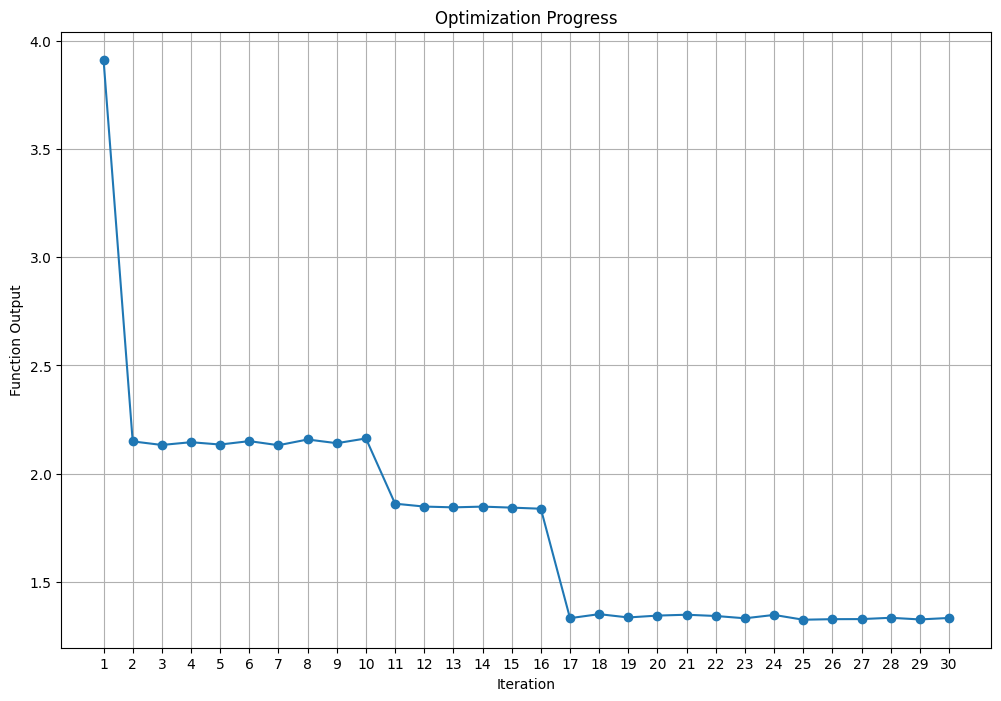

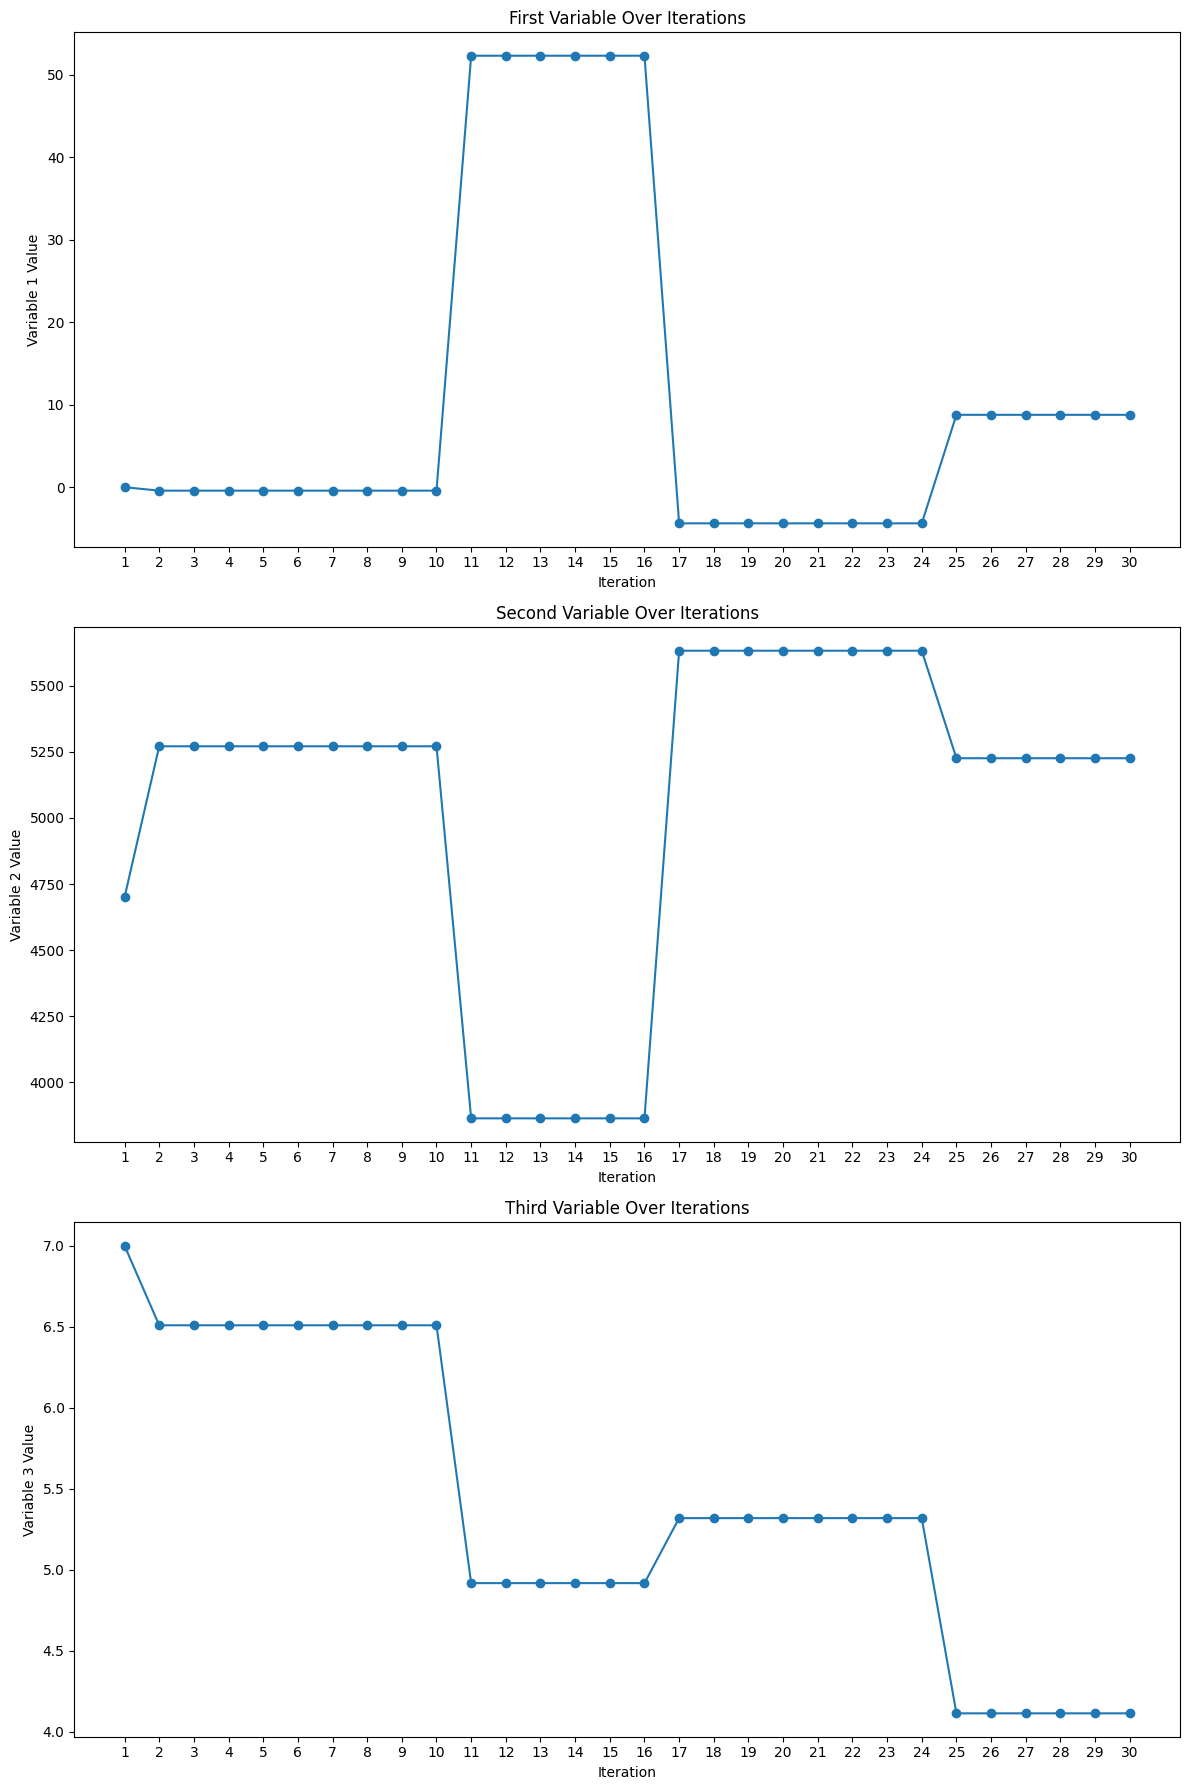

In [18]:
x_values, y_values = zip(*results)

# You might want to process x_values if they are multidimensional
# For example, you could plot one parameter at a time or some function of the parameters

# Plotting
iterations = list(range(1, len(y_values) + 1))  # Starting from 1 to the number of iterations

plt.figure(figsize=(12, 8))
plt.plot(iterations, y_values, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Function Output')
plt.title('Optimization Progress')
plt.xticks(iterations) 
plt.grid(True)
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # Adjust the figure size as needed

iterations = list(range(1, len(x_values) + 1))

x1_values, x2_values, x3_values = zip(*x_values)

# First variable plot
axs[0].plot(iterations, x1_values, marker='o', linestyle='-')
axs[0].set_title('First Variable Over Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Variable 1 Value')
axs[0].set_xticks(iterations)  # Set x-axis ticks

# Second variable plot
axs[1].plot(iterations, x2_values, marker='o', linestyle='-')
axs[1].set_title('Second Variable Over Iterations')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Variable 2 Value')
axs[1].set_xticks(iterations)  # Set x-axis ticks

# Third variable plot
axs[2].plot(iterations, x3_values, marker='o', linestyle='-')
axs[2].set_title('Third Variable Over Iterations')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Variable 3 Value')
axs[2].set_xticks(iterations)  # Set x-axis ticks

plt.tight_layout()
plt.show()

In [ ]:
PARAMS = [
    "t_emit",
    "momentum",
    "beta",
    "alpha",
    "l_emit",
    "pz_std",
    "vd_dist",
    "w1_length",
    "w1_angle",
    "w2_length",
    "w2_angle",
    "drift_length",
    "rf_freq",
    "rf_phase",
    "rf_length",
    "rf_grad"
]
# Show parameters
{k:globals()[k] for k in PARAMS}

{'t_emit': 0.145,
 'momentum': 100,
 'beta': 0.03,
 'alpha': 0.7,
 'l_emit': 1,
 'pz_std': 1,
 'vd_dist': 24,
 'w1_length': 7.498470237012953,
 'w1_angle': 47.045876731630415,
 'w2_length': 5.987709516854379,
 'w2_angle': 56.828937918078736,
 'drift_length': 16000,
 'rf_freq': 0.025,
 'rf_phase': 0.0005802320670262949,
 'rf_length': 5500.98783997892,
 'rf_grad': 4.829977594880215}